In [1]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import Tensor

In [2]:
def process_motion_capture_data(file_path, num_times=309):
    # Dictionary with the number of dimensions for each body part
    # return: np.ndarray; of shape (62, #time_points)
    # i.e. 62 outputs, each output has #time_points input locations.
    dimensions_dict = {
        'root': 6, 'lowerback': 3, 'upperback': 3, 'thorax': 3, 
        'lowerneck': 3, 'upperneck': 3, 'head': 3, 'rclavicle': 2, 
        'rhumerus': 3, 'rradius': 1, 'rwrist': 1, 'rhand': 2, 
        'rfingers': 1, 'rthumb': 2, 'lclavicle': 2, 'lhumerus': 3, 
        'lradius': 1, 'lwrist': 1, 'lhand': 2, 'lfingers': 1, 
        'lthumb': 2, 'rfemur': 3, 'rtibia': 1, 'rfoot': 2, 
        'rtoes': 1, 'lfemur': 3, 'ltibia': 1, 'lfoot': 2, 
        'ltoes': 1
    }

    # Calculate the total number of dimensions
    total_dimensions = sum(dimensions_dict.values())

    # Initialize the numpy array
    data_array = np.zeros((total_dimensions, num_times))

    # Open the file and process each line
    with open(file_path, 'r') as file:
        # Skip the first three lines (header)
        for _ in range(3):
            next(file)

        current_timestamp = 0
        current_dimension = 0
        for line in file:
            if line.strip().isdigit():
                # New timestamp line found
                current_timestamp = int(line.strip()) - 1
                current_dimension = 0  # Reset dimension counter for each timestamp
            else:
                # Process body part data
                parts = line.strip().split()
                body_part = parts[0]
                num_dims = dimensions_dict[body_part]
                values = np.array([float(v) for v in parts[1:1+num_dims]])
                data_array[current_dimension:current_dimension+num_dims, current_timestamp] = values
                current_dimension += num_dims

    return data_array

# Load in data

In [3]:
mocap_txt_data_folder = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/data/CMU_motion_capture/txt_files'
txt_data_name = '64_08amc' # 08_02amc.txt (309); 09_01amc.txt (148); 64_08amc.txt (364); 118_03amc.txt (497)
txt_data_path = f'{mocap_txt_data_folder}/{txt_data_name}.txt'

data = process_motion_capture_data(txt_data_path, num_times=364)
print(data.shape)

(62, 364)


# Have a plot

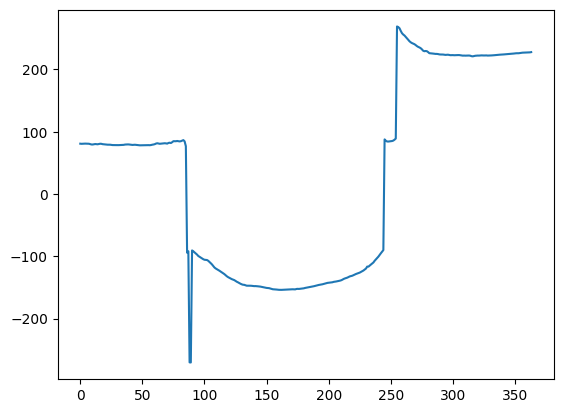

In [4]:
plt.plot(data[47])

In [5]:
print(data.shape)

(62, 364)


# Select outputs according to NSR

In [6]:
def compute_signal_to_noise_ratio(time_series:Tensor):
    '''
    Compute SNR for all time series.
    Arg:
        time_series: of shape (num_time_series, num_timeframes)
    Return:
        a list of SNR
    '''
    snr_list = []
    for i in range(time_series.shape[0]):
        # first standardize data:
        # time_series[i] = (time_series[i] - time_series[i].mean()) / (time_series[i].std() + 1e-8)

        # Calculate the mean (signal)
        signal_mean = time_series[i].mean()
        
        # Calculate the standard deviation (noise)
        noise_std = time_series[i].std()

        # Compute SNR. If noise_std is zero, handle the division by zero case.
        if noise_std <= 1e-10:
            snr = float('inf')  # Infinite SNR if there is no noise
        else:
            snr = signal_mean / noise_std

        # Convert to dB (20*log10(snr)) and append to list
        # We use 20*log10 for amplitude ratio. For power ratio, it would be 10*log10.
        snr_db = float(20 * np.log10(abs(snr)))
        snr_list.append(snr_db)

    # Sort the SNR list in descending order and get the sorted indices
    sorted_indices = np.argsort(snr_list)[::-1]

    return snr_list, sorted_indices.tolist()

def count_up_and_down(time_series:Tensor):
    '''
    Count how many up and down in the time series.
    '''

    origin_ts = time_series[:, 1:]
    translate_ts = time_series[:, :-1]
    diff = origin_ts - translate_ts

    origin_diff = diff[:, 1:]
    translate_diff = diff[:, :-1]
    sign_change = ((origin_diff * translate_diff) > 0)
    

    return None

def mean_absolute_change(time_series: Tensor):

    time_series = torch.tensor(time_series)
    
    curr_mac_list = []
    for i in range(time_series.shape[0]):
        time_series[i] = (time_series[i] - time_series[i].mean()) / (time_series[i].std() + 1e-13)
        # current output mean absolute change:
        curr_mac = torch.abs(torch.diff(time_series[i])).mean()
        curr_mac_list.append(curr_mac.item())
        
    return np.array(curr_mac_list)

def remove_too_small_outputs(time_series: Tensor, threshold=1e-3):
    '''
    Some time series are varying in a very small range, looks like pure noise.
    Remove them.
    '''
    index_to_keep = []
    for i in range(time_series.shape[0]):
        cur_max = time_series[i].max()
        cur_min = time_series[i].min()
        maxi_diff = cur_max - cur_min
        if maxi_diff > threshold:
            index_to_keep.append(i)
    
    return time_series[index_to_keep]


In [7]:
'''
data_snr_list, data_sorted_idx = compute_signal_to_noise_ratio(time_series=data)
db_threshold = 5
print(f'How many output with snr over {db_threshold}? Answer: ', ((np.array(data_snr_list) > db_threshold) * 1).sum())
data_selected = data[(np.array(data_snr_list) > db_threshold)]
print(data_selected.shape)
data_selected_2 = remove_too_small_outputs(data_selected, threshold=1e-3)
print(data_selected_2.shape)
'''

"\ndata_snr_list, data_sorted_idx = compute_signal_to_noise_ratio(time_series=data)\ndb_threshold = 5\nprint(f'How many output with snr over {db_threshold}? Answer: ', ((np.array(data_snr_list) > db_threshold) * 1).sum())\ndata_selected = data[(np.array(data_snr_list) > db_threshold)]\nprint(data_selected.shape)\ndata_selected_2 = remove_too_small_outputs(data_selected, threshold=1e-3)\nprint(data_selected_2.shape)\n"

In [8]:
mac_list = mean_absolute_change(data)

In [9]:
data_selected_mac_ = data[mac_list < 0.1]
data_selected_mac = remove_too_small_outputs(data_selected_mac_)
print(data_selected_mac.shape)

(56, 364)


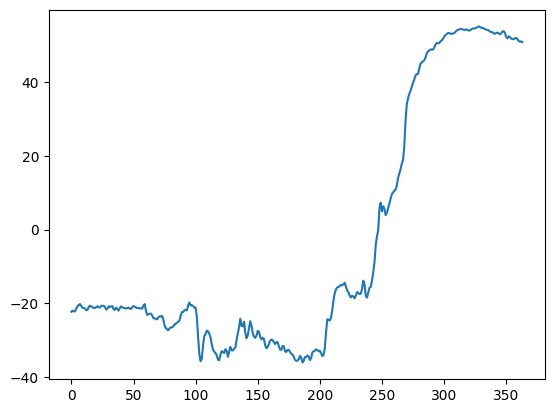

In [23]:
plt.plot(data_selected_mac[55])

# Save data

In [11]:
'''
csv_folder_path = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/data/CMU_motion_capture/csv_files'
csv_data_name = txt_data_name
csv_to_save = f'{csv_folder_path}/{csv_data_name}.csv'
pd.DataFrame(data_selected_mac).to_csv(csv_to_save)
'''

"\ncsv_folder_path = '/Users/jiangxiaoyu/Desktop/All Projects/Scalable_LVMOGP/data/CMU_motion_capture/csv_files'\ncsv_data_name = txt_data_name\ncsv_to_save = f'{csv_folder_path}/{csv_data_name}.csv'\npd.DataFrame(data_selected_mac).to_csv(csv_to_save)\n"